In [14]:
import argparse
from pathlib import Path
from pandas import concat, melt, merge, read_csv, value_counts
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.text import Annotation
from matplotlib.ticker import FuncFormatter
rcParams['figure.facecolor'] = 'white'
import textwrap
from constant import CRITERIA
import itertools
import numpy as np
from functools import reduce
from adjustText import adjust_text
from math import ceil
from string import ascii_lowercase

In [15]:
# networks = ["RH0_only", "RH0_small", "RH0_large"]
RHs = ["RH0", "RH2"]
load_sets = ["only", "small", "large"]
seasons = ["winter", "spring", "summer", "fall"]
loadtype = ["max"]
lengths = ["short"]
all_cases = ["_".join([rh, ls, s, lo, le]) for rh, ls, s, lo, le in itertools.product(RHs, load_sets, seasons, loadtype, lengths)]

In [16]:
def assign_tech_numbers(row_name):
    new_cols = dict()
    tech_numbers = row_name.split(" & ")
    new_cols["Solar"] = int(tech_numbers[0].split(" ")[0])
    new_cols["SOFC"] = int(tech_numbers[1].split(" ")[0])
    new_cols["Diesel"] = int(tech_numbers[2].split(" ")[0])
    return new_cols

In [17]:
def get_row_bucket(row):
    solar = row["Solar"] * 3.8 # for grouping by kW capacity
    sofc = row["SOFC"] * 10  # for grouping by kW capacity
    diesel = row["Diesel"] * 10  # for grouping by kW capacity
    total = solar + sofc + diesel
    if solar > 0.5 * total:
        return 'Solar'
    elif sofc > 0.5 * total:
        return 'SOFC'
    elif diesel > 0.5 * total:
        return "Diesel"
    else:
        return "Misc"

In [18]:
from pprint import pprint
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

def understand_buckets(plotfolder, network, length, bucketed_df):
    idx = 0
    for bucket_name, bucketed_data in bucketed_df:
        figure_data = []
    
        # print(bucket_name)
        # pprint(bucketed_data.shape)
        bucketed_data["Solar kW"] = bucketed_data["Solar"] * 3.8
        bucketed_data["SOFC kW"] = bucketed_data["SOFC"] * 10
        bucketed_data["Diesel kW"] = bucketed_data["Diesel"] * 10
        breakdown_data = bucketed_data[["Solar kW", "SOFC kW", "Diesel kW"]]
        # fig = px.line_polar(r = [], breakdown_data, line_close=True)
        # fig.show()
        for row in breakdown_data.values:
            figure_data.append(go.Scatterpolar(
                    r = row,
                    theta = breakdown_data.columns.values,
                    fill='toself',
                    fillcolor="rgba(190,190,190,0.1)",
                    line={
                        "color": "rgba(190,190,190,0.1)",
                        # "width": 0.01
                    },
                    marker={
                        "color": "rgba(190,190,190,0.1)",
                        # "width": 0.01
                    }
                ))
        fig = go.Figure(
                data = figure_data,
                layout=go.Layout(
                    title=go.layout.Title(text=f'({ascii_lowercase[idx]}) {bucket_name}', x=0.5),
                    font={
                        "size":20
                    },
                    showlegend=False
                )
            )
        
        
        fig.update_layout(polar=dict(
            radialaxis=dict(
                visible=True
            )
        ))

        pyo.plot(fig)
        
        fig.write_html(plotfolder.joinpath(f"{network}_{length}_{bucket_name}.html"))

        idx += 1

In [19]:
def category_datapoint_label_formatter(crit):
    criterion_idx = CRITERIA.index(crit)
    if criterion_idx == 0:
        return lambda value: "$" + "{:,}".format(round(value/1e6, 1)) + "M"
    if criterion_idx == 1:
        return lambda value: "{:,}".format(int(int(value)/1e6)) + "M lbs"
    if criterion_idx > 1 and criterion_idx < 5:
        return lambda value: "{:,}".format(int(value)) + " lbs"
    if criterion_idx == 5:
        return lambda value: "{:.0%}".format(float(value))
    if criterion_idx == 6:
        return lambda value: "{:,}".format(abs(round(float(value)/1e6, 1))) + "M"

In [20]:
def create_box_and_whisker(datafolder, plotfolder, pad=3, figsize=(25,10), include=[True]*len(CRITERIA), network="all_branches", winter_loadtype="min", length="short", props={}, save_file=True):
    all_case_data = None
    for season in seasons:
        case = "_".join([network, season, winter_loadtype if season == "winter" else "max", length])
        case_filepath = datafolder.joinpath(f"{case}_all.csv")
        case_data = read_csv(case_filepath, index_col=[0])
        case_data = concat([case_data, case_data.apply(lambda row: assign_tech_numbers(row.name), axis = "columns", result_type = "expand")], axis='columns')
        all_case_data = case_data if all_case_data is None else concat([all_case_data, case_data])
    all_case_data["Bucket"] = all_case_data.aggregate(get_row_bucket, axis = 1)
    all_case_data_groupby = all_case_data.groupby("Bucket")
    understand_buckets(plotfolder, network, length, all_case_data_groupby)
    included_criteria = np.array(CRITERIA)[include]
    fig, axs = plt.subplots(2, ceil(len(included_criteria) / 2), figsize=figsize)
    axs = axs.reshape(1, ceil(len(included_criteria) / 2) * 2)[0]
    fig.tight_layout(pad=pad)
    # fig.suptitle(f"{network.replace('_', ' ').title()}, {'72 Hour' if length=='long' else '36 Hour'} Outage Duration, All Systems, Bucketed By Majority Technology", fontsize=20, y=1)
    formatter_lambda = lambda crit: FuncFormatter(lambda y_val, tick_pos: category_datapoint_label_formatter(crit)(y_val))
    for idx, criterion in enumerate(included_criteria):
        sb.boxplot(data=all_case_data, x="Bucket", y=criterion, ax=axs[idx], order = value_counts(all_case_data['Bucket']).sort_index().index, **props).set(title=f"({ascii_lowercase[idx]}) {criterion}")
        # axs[idx].set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text(),9)) for ticklabel in axs[idx].get_xticklabels()], rotation=90)
        axs[idx].set(xlabel=None)
        axs[idx].set(ylabel=None)
        axs[idx].yaxis.set_major_formatter(formatter_lambda(criterion))
        # axs[idx].set_ylim(bottom=0)
        # pass
    for ax in axs[len(CRITERIA):]:
        fig.delaxes(ax)
    if save_file:
        fig.savefig(plotfolder.joinpath(f"{network}_{length}_all.png"))

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/c/Users/Arnav/Documents/Research/resilience_hub_MC ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 
Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/c/Users/Arnav/Documents/Research/resilience_hub_MC ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 
Start : This command cannot be run due to the error: The system cannot f

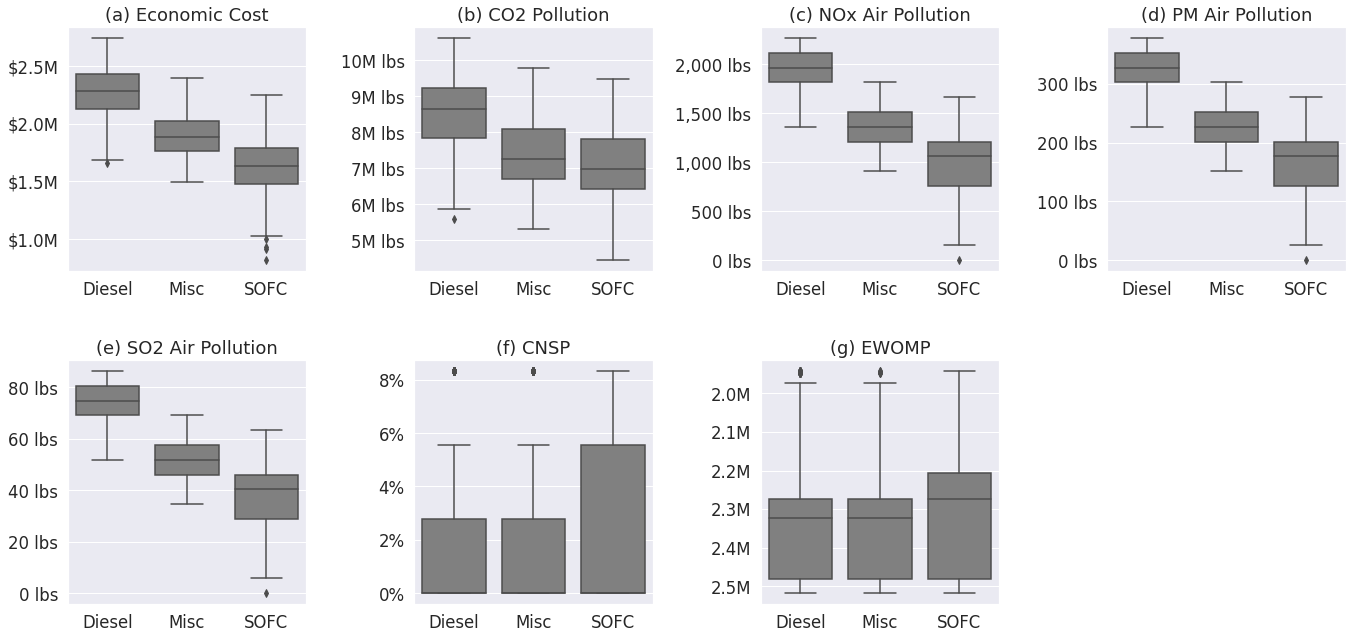

In [11]:
sb.set_theme(font_scale=1.5)

rcParams['figure.facecolor'] = 'white'
create_box_and_whisker(
    network = "RH0_large",
    length="short",
    include = [True, True, True, True, True, True, True],
    winter_loadtype="max", 
    figsize=(20,10),
    pad=3,
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/BoxAndWhiskers"),
    props={'boxprops':{'facecolor':'gray'}},
    save_file=False)

In [21]:
def annotation_text_formatter(crit):
    criterion_idx = CRITERIA.index(crit)
    if criterion_idx == 0:
        return lambda value: "$" + "{:,}".format(round(int(value)/1e6,1)) + "M"
    if criterion_idx == 1:
        return lambda value: "{:,}".format(round(int(value)/1e6,1)) + "M lbs"
    if criterion_idx > 1 and criterion_idx < 5:
        return lambda value: "{:,}".format(int(value)) + " lbs"
    if criterion_idx == 5:
        return lambda value: "{:.0%}".format(float(value))
    if criterion_idx == 6:
        return lambda value: "{:,}".format(abs(int(value)))

In [22]:
from collections import defaultdict
from constant import FIXED_COSTS, Technology

class keydefaultdict(defaultdict):

    def __init__(self, default_factory=None, all_hues=None):
        super().__init__(default_factory)
        self.max_solar = 0
        self.max_sofc = 0
        self.max_diesel = 0
        for hue in all_hues:
            tech_nums = assign_tech_numbers(hue)
            self.max_solar = max(self.max_solar, tech_nums["Solar"])
            self.max_sofc = max(self.max_sofc, tech_nums["SOFC"])
            self.max_diesel = max(self.max_diesel, tech_nums["Diesel"])

    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError( key )
        else:
            ret = self[key] = self.default_factory(key, self.max_solar, self.max_sofc, self.max_diesel)
            return ret

def palette_color_for_series(hue, max_solar, max_sofc, max_diesel):
    tech_nums = assign_tech_numbers(hue)
    solar = tech_nums["Solar"]# * 3.8 # for grouping by kW capacity
    sofc = tech_nums["SOFC"]# * 10  # for grouping by kW capacity
    diesel = tech_nums["Diesel"]# * 10  # for grouping by kW capacity
    # total = solar+sofc+diesel
    rgb_val = ((diesel/max_diesel if max_diesel != 0 else 0), (solar/max_solar if max_solar != 0 else 0), (sofc/max_sofc if max_sofc != 0 else 0))
    return rgb_val

def color_by_bucket_shade_by_percent(hue, max_solar, max_sofc, max_diesel):
    tech_nums = assign_tech_numbers(hue)
    bucket = get_row_bucket(tech_nums)
    rgba = []
    if bucket == "Solar":
        idx = int((tech_nums["Solar"]/max_solar if max_solar != 0 else 0) * (len(sb.color_palette("Oranges"))-1))
        return sb.color_palette("Oranges")[idx]
        # rgba = list(sb.color_palette()[2])
        # rgba.append(1-tech_nums["Solar"]/max_solar if max_solar != 0 else 0)
    if bucket == "Diesel":
        idx = int((tech_nums["Diesel"]/max_diesel if max_diesel != 0 else 0) * (len(sb.color_palette("Reds"))-1))
        return sb.color_palette("Reds")[idx]
        # rgba = list(sb.color_palette()[0])
        # rgba.append(1-tech_nums["Diesel"]/max_diesel if max_diesel != 0 else 0)
    if bucket == "SOFC":
        idx = int((tech_nums["SOFC"]/max_sofc if max_sofc != 0 else 0) * (len(sb.color_palette("Blues"))-1))
        return sb.color_palette("Blues")[idx]
        # rgba = list(sb.color_palette()[1])
        # rgba.append(1-tech_nums["SOFC"]/max_sofc if max_sofc != 0 else 0)
    if bucket == "Misc":
        idx = int((tech_nums["Solar"]/max_solar if max_solar != 0 else 0) * (len(sb.color_palette("gray"))-1))
        return sb.color_palette("gray")[idx]
        # rgba = list(sb.color_palette()[7])
        # rgba.append(1-tech_nums["Solar"]/max_solar if max_solar != 0 else 0)
    
    # return rgba



In [23]:
def create_normalized_nd_line_graph(datafolder, plotfolder, no_sox_no2=False, font_size = 20, axis_font_size=20, marker_size=50, color_palette = "autumn", save_image=True):
    mpl.rcParams['font.size'] = str(font_size)
    mpl.rcParams['axes.labelsize'] = str(axis_font_size)
    mpl.rcParams['axes.titlesize'] = str(axis_font_size)
    mpl.rcParams['lines.markersize'] = str(marker_size)
    for case in all_cases:
    # if True:
    #     case = all_cases[0]
        mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])
    
        case_filepath = datafolder.joinpath(f"{case}_nd.csv")
        case_data = read_csv(case_filepath, index_col=[0])
        if no_sox_no2:
            case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
        min_val = case_data.min()
        max_val = case_data.max()

        worst_val = min_val.copy()
        best_val = max_val.copy()

        # # Gotta switch the best and worst values for EWOMP, because we want distance from min, not distance from max ?????
        # temp_val = min_val["EWOMP"]
        # min_val["EWOMP"] = max_val["EWOMP"]
        # max_val["EWOMP"] = temp_val

        normalized_case_data=(max_val-case_data)/(max_val-min_val)
        normalized_case_data.fillna(0, inplace=True)

        melted_case_data = normalized_case_data.melt(ignore_index=False)
        melted_case_data["Index"] = melted_case_data.index
        # mean_case_data = case_data.mean(axis=1)
        plt.figure(figsize=(11,7))
        with plt.rc_context({'lines.linewidth': 2.5}):
            ax = sb.pointplot(data=melted_case_data, x="variable", y="value", hue="Index", errorbar=None, markers=[next(mks) for i in melted_case_data.index.unique()], palette=color_palette)#, palette=keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_case_data.index.values))
            # plt.setp(ax.collections, sizes=[30])
        ax.set(xlabel=None, ylabel="Normalized Value")
        plt.title(f"Non-Dominated Set Performance for {case.replace('_', ' ').title()}", fontsize=font_size, pad=20)
        ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text(),9)) for ticklabel in ax.get_xticklabels()])
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.tick_params(axis='x', which='major', pad=10)
        # ax.xaxis.labelpad = 25
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), borderaxespad=0, ncol=2)#, fontsize=font_size)

        best_annotations = []

        for idx, criterion in enumerate(case_data.columns):
            # if no_sox_no2 and (idx==2 or idx==4):
            #     continue
            annotation_formatter = annotation_text_formatter(criterion)
            hue_vals = []
            for collection in ax.collections:
                hue_vals.append([point for point in collection.get_offsets().data if point[0] == idx][0][1])
            worst_hue_val = max(hue_vals)
            worst_annotation = annotation_formatter(worst_val[criterion])
            best_hue_val = min(hue_vals)
            best_annotation = annotation_formatter(best_val[criterion])
            if worst_hue_val != best_hue_val:
                plt.annotate(worst_annotation, xy=(idx, worst_hue_val), xytext=(idx-0.3,worst_hue_val+0.01), annotation_clip=False)
            min_x_offset=0.3
            min_y_offset=0.05
            best_annotations.append(plt.annotate(best_annotation, xy=(idx, best_hue_val), xytext=(idx-min_x_offset,best_hue_val-min_y_offset), annotation_clip=False))

        # adjust_text(best_annotations, only_move = {'points':'x', 'text':'x', 'objects':'x'})#, force_text=(0.5,1.25))#
        if save_image:
            ax.figure.savefig(plotfolder.joinpath(f"{case}_nd.png"), bbox_inches = "tight")

In [24]:
RHs = ["RH0"]#, "RH0", "RH2"]
load_sets = ["large"]#, "large", "only", "small"]
seasons = ["winter", "spring", "summer", "fall"]
loadtype = ["max"]
lengths = ["short"]#, "short", "long"]
all_cases = ["_".join([rh, ls, s, lo, le]) for rh, ls, s, lo, le in itertools.product(RHs, load_sets, seasons, loadtype, lengths)]

# networks = ["RH0_only", "RH0_large"]
# seasons = ["winter", "spring", "summer", "fall"]
# loadtype = ["max"]
# lengths = ["short"]
# all_cases = ["_".join([n, s, lo, le]) for n, s, lo, le in itertools.product(networks, seasons, loadtype, lengths)]

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.4, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.8, 0.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.4, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.8, 0.0)) for a

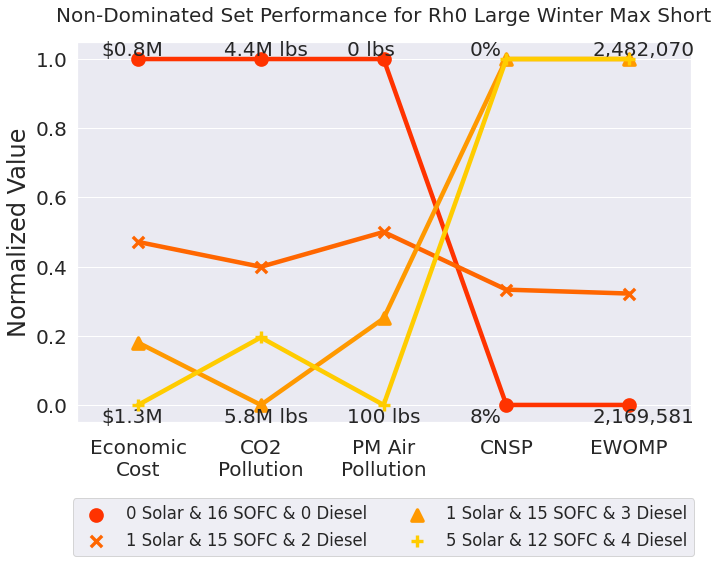

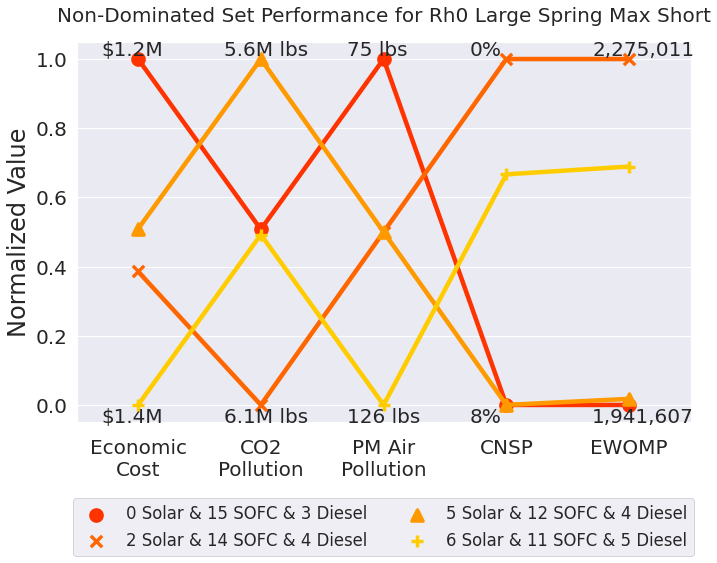

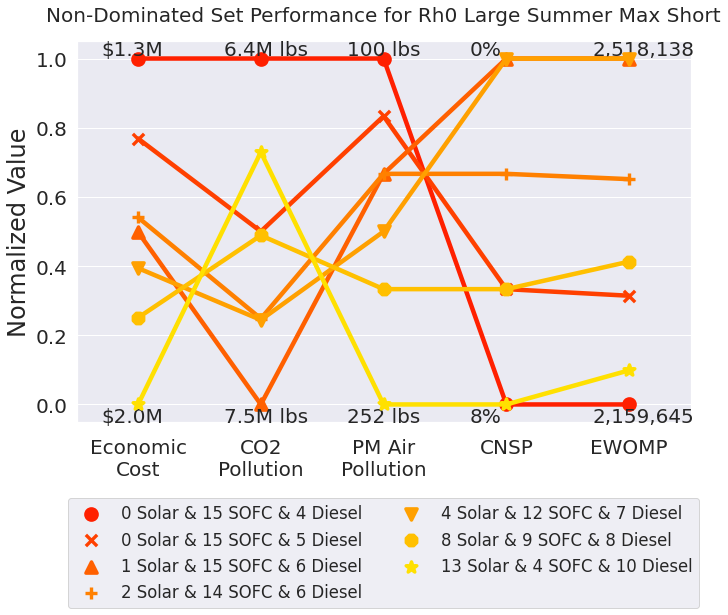

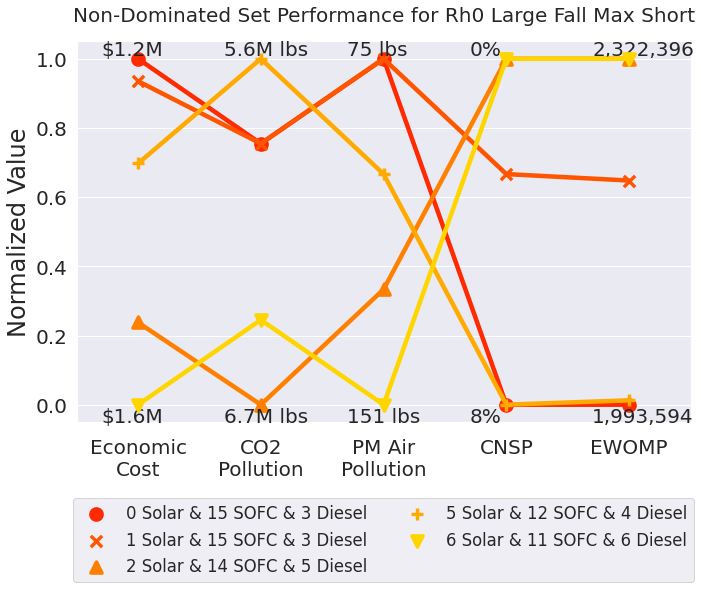

In [25]:
sb.set(font_scale=1.5)
create_normalized_nd_line_graph(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/NormalizedND"),
    no_sox_no2=True,
    font_size=20,
    axis_font_size=24,
    color_palette="autumn",
    save_image=True
    )

In [26]:
def compare_RHs_one_season(
    datafolder, plotfolder, no_sox_no2=False, font_size = 20, axis_font_size=20, marker_size=50, save_image=True,
    locs=["RH0", "RH2"], sizes=["large", "small"], season="winter", nd_season="winter", duration="short"):

    mpl.rcParams['font.size'] = str(font_size)
    mpl.rcParams['axes.labelsize'] = str(axis_font_size)
    mpl.rcParams['axes.titlesize'] = str(axis_font_size)
    mpl.rcParams['lines.markersize'] = str(marker_size)

    mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])

    nd_indices = [None, None]
    if nd_season != season:
        nd_cases = ["_".join([locs[0], sizes[0], nd_season, "max", duration]), "_".join([locs[1], sizes[1], nd_season, "max", duration])]
        for idx, nd_case in enumerate(nd_cases):
            nd_case_filepath = datafolder.joinpath(f"{nd_case}_nd.csv")
            nd_case_data = read_csv(nd_case_filepath, index_col=[0])
            nd_indices[idx] = nd_case_data.index
    
    comparison_cases = ["_".join([locs[0], sizes[0], season, "max", duration]), "_".join([locs[1], sizes[1], season, "max", duration])]
    min_val = None
    max_val = None
    comparison_dfs = []
    for idx, case in enumerate(comparison_cases):
        if nd_indices[idx] is None:
            case_filepath = datafolder.joinpath(f"{case}_nd.csv")
            case_data = read_csv(case_filepath, index_col=[0])
        else:
            case_filepath = datafolder.joinpath(f"{case}_generated.csv")
            case_data = read_csv(case_filepath, index_col=[0])
            case_data = case_data.loc[[ind for ind in nd_indices[idx]]]
        if no_sox_no2:
            case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
        min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min, 0)
        max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max, 0)
        comparison_dfs.append(case_data)
    
    # case_data = concat(comparison_dfs[0], comparison_dfs[1])
    case0_data = comparison_dfs[0]
    case1_data = comparison_dfs[1]

    worst_val = min_val
    best_val = max_val

    normalized_case0_data=(max_val-case0_data)/(max_val-min_val)
    normalized_case0_data.fillna(0, inplace=True)
    melted_case0_data = normalized_case0_data.melt(ignore_index=False)
    melted_case0_data["Index"] = melted_case0_data.index

    normalized_case1_data=(max_val-case1_data)/(max_val-min_val)
    normalized_case1_data.fillna(0, inplace=True)
    melted_case1_data = normalized_case1_data.melt(ignore_index=False)
    melted_case1_data["Index"] = melted_case1_data.index
    
    # mean_case_data = case_data.mean(axis=1)
    plt.figure(figsize=(11,7))
    with plt.rc_context({'lines.linewidth': 2.5}):
        ax = sb.pointplot(data=melted_case0_data, x="variable", y="value", hue="Index", errorbar=None, markers=[next(mks) for i in melted_case0_data.index.unique()], palette="autumn")#, palette=keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_case_data.index.values))
        dummy1, = plt.plot([0], marker='None',
                linestyle='None', label='RH0 Non-Dominated Options')
        plot1_collections = list(ax.collections).copy()
        sb.pointplot(data=melted_case1_data, x="variable", y="value", hue="Index", errorbar=None, markers=[next(mks) for i in melted_case1_data.index.unique()], palette="cool", ax=ax)
        dummy2, = plt.plot([0], marker='None',
                linestyle='None', label='RH2 Non-Dominated Options')
        plot2_collections = [collection for collection in ax.collections if collection not in plot1_collections]
        # plt.setp(ax.collections, sizes=[30])
    ax.set(xlabel=None, ylabel="Normalized Value")
    # plt.title(f"Non-Dominated Set Performance for {' & '.join([case.replace('_', ' ').title() for case in comparison_cases])}", fontsize=font_size, pad=20)
    ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text(),9)) for ticklabel in ax.get_xticklabels()])
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='x', which='major', pad=10)
    # ax.xaxis.labelpad = 25
    plt.legend(
        [dummy1] + plot1_collections + [dummy2] + plot2_collections,
        ["RH0 Non-Dominated Options"] + [collection.get_label() for collection in plot1_collections] + ["RH2 Non-Dominated Options"] + [collection.get_label() for collection in plot2_collections],
        loc='upper center', bbox_to_anchor=(0.5, -0.2), borderaxespad=0, ncol=2)#, fontsize=font_size)

    best_annotations = []

    for idx, criterion in enumerate(case_data.columns):
        # if no_sox_no2 and (idx==2 or idx==4):
        #     continue
        annotation_formatter = annotation_text_formatter(criterion)
        hue_vals = []
        for collection in ax.collections:
            hue_vals.append([point for point in collection.get_offsets().data if point[0] == idx][0][1])
        worst_hue_val = max(hue_vals)
        worst_annotation = annotation_formatter(worst_val[criterion])
        best_hue_val = min(hue_vals)
        best_annotation = annotation_formatter(best_val[criterion])
        if worst_hue_val != best_hue_val:
            plt.annotate(worst_annotation, xy=(idx, worst_hue_val), xytext=(idx-0.3,worst_hue_val+0.01), annotation_clip=False)
        min_x_offset=0.3
        min_y_offset=0.05
        best_annotations.append(plt.annotate(best_annotation, xy=(idx, best_hue_val), xytext=(idx-min_x_offset,best_hue_val-min_y_offset), annotation_clip=False))

    # adjust_text(best_annotations, only_move = {'points':'x', 'text':'x', 'objects':'x'})#, force_text=(0.5,1.25))#
    if save_image:
        ax.figure.savefig(plotfolder.joinpath(f"{'_'.join(['_'.join([locs[0], sizes[0]]), '_'.join([locs[1], sizes[1]])])}_{nd_season}_nd_in_{season}_comparison.png"), bbox_inches = "tight")

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.4, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.8, 0.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



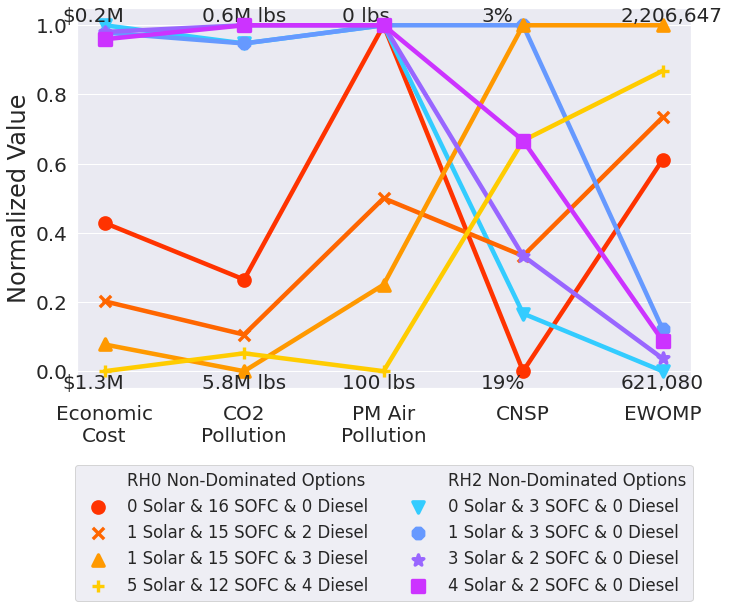

In [30]:
compare_RHs_one_season(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/NormalizedND"),
    no_sox_no2=True,
    font_size=20,
    axis_font_size=24,
    season="fall",
    nd_season="winter",
    save_image=True
    )

In [34]:
class weight_obj():
    def __init__(self, name, weights_dict):
        self.weights_dict = weights_dict
        self.name = name
    
    def get_weight(self, criterion):
        if criterion in self.weights_dict:
            return self.weights_dict[criterion]
        raise Exception(f"No weight was given for criterion {criterion}")
    
    def get_name(self):
        return self.name



In [54]:
def create_nd_seasonal_performance_line_graph(datafolder, plotfolder, length, system_type="generated", network="", nd_season="", color_palette="autumn", save_image=True, marker_size=50, no_sox_no2=False, weights=None):
    
    mpl.rcParams['lines.markersize'] = str(marker_size)
    for nd_season in seasons:

        

        nd_index = None
        nd_case = "_".join([network, nd_season, "max", length])
        nd_case_filepath = datafolder.joinpath(f"{nd_case}_nd.csv")
        nd_case_data = read_csv(nd_case_filepath, index_col=[0])
        nd_index = nd_case_data.index

        season_dfs = []
        min_val = None
        max_val = None
        for season in seasons:
            case = "_".join([network, season, "max", length])
            if season==nd_season:
                case_filepath = datafolder.joinpath(f"{case}_nd.csv")
            else:
                case_filepath = datafolder.joinpath(f"{case}_{system_type}.csv")
            case_data = read_csv(case_filepath, index_col=[0])
            if season != nd_season:
                case_data = case_data.loc[[ind for ind in nd_index]]
            if no_sox_no2:
                case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
            min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min)
            max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max)

            season_dfs.append(case_data)
        
        normalized_dfs = []
        for season_data in season_dfs:
            normalized_season_data=(max_val-season_data)/(max_val-min_val)
            normalized_season_data.fillna(0, inplace=True)
            if no_sox_no2:
                criteria_list = CRITERIA.copy()
                del criteria_list[4]
                del criteria_list[2]
            else:
                criteria_list = CRITERIA
            normalized_season_data["equal_weight_score"] = sum((normalized_season_data[criterion] * (weights.get_weight(criterion) if weights is not None else 1) for criterion in criteria_list))
            normalized_season_data["Index"] = normalized_season_data.index
            normalized_season_data = normalized_season_data[['Index', 'equal_weight_score']]
            normalized_dfs.append(normalized_season_data)
        
        merge_01 = merge(normalized_dfs[0], normalized_dfs[1], on='Index', how='inner', suffixes=(f"_{seasons[0]}", f"_{seasons[1]}"))
        merge_23 = merge(normalized_dfs[2], normalized_dfs[3], on='Index', how='inner', suffixes=(f"_{seasons[2]}", f"_{seasons[3]}"))
        merge_4 = merge(merge_01, merge_23, on="Index", how="inner", suffixes=(None,None))
        if len(merge_4) == 0:
            print("No systems are evaluated across all seasons")
            continue
        # merge_4.set_index("Index", inplace=True)
        melted_df = melt(merge_4, id_vars = ["Index"])
        # melted_df.set_index("Index", inplace=True)
        
        plt.figure(figsize=(11,7))
        mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])
        
        with plt.rc_context({'lines.linewidth': 2.5}):
            ax = sb.pointplot(data=melted_df, x="variable", y="value", hue="Index", errorbar=None, palette=color_palette, markers=[next(mks) for i in melted_df.index.unique()])#keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_df["Index"].values))
        ax.set(xlabel=None, ylabel="Equal Sum of Normalized Performance")
        # ax.set_ylim(bottom=0, top=1)
        plt.title(f"Equal-Weighted Performance for {network.replace('_', ' ').title()} For Seasonal Peak Loads", fontsize=20, pad=10)
        ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text().split("_")[-1].title(), 9)) for ticklabel in ax.get_xticklabels()])
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=2)
        if save_image:
            ax.figure.savefig(plotfolder.joinpath(f"{network}_max_{length}_{nd_season}_nd.png"), bbox_inches = "tight")

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.4, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.8, 0.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.4, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.8, 0.0)) for a

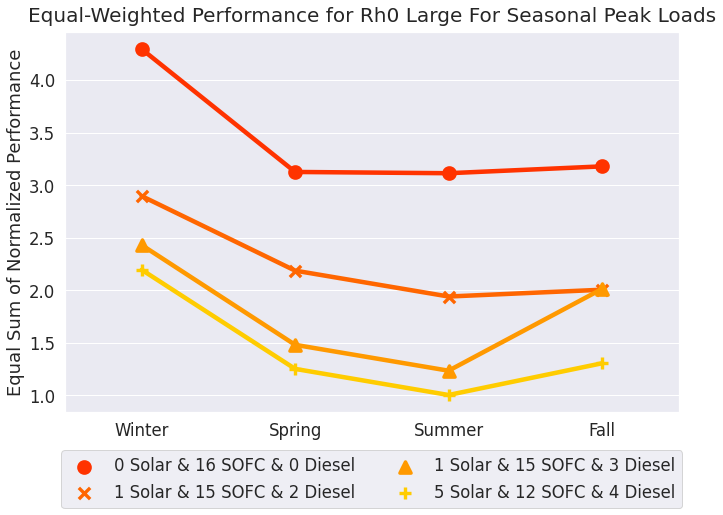

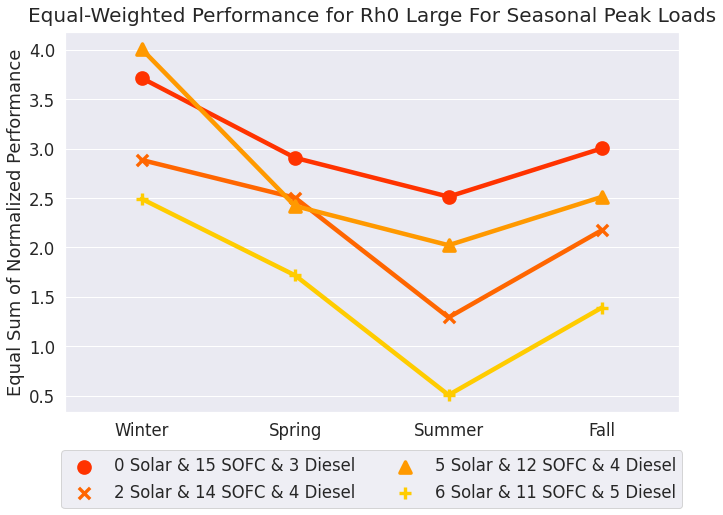

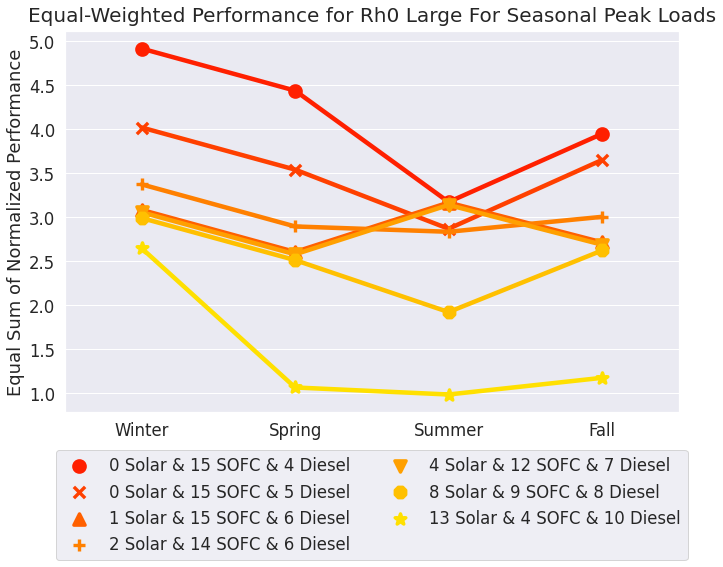

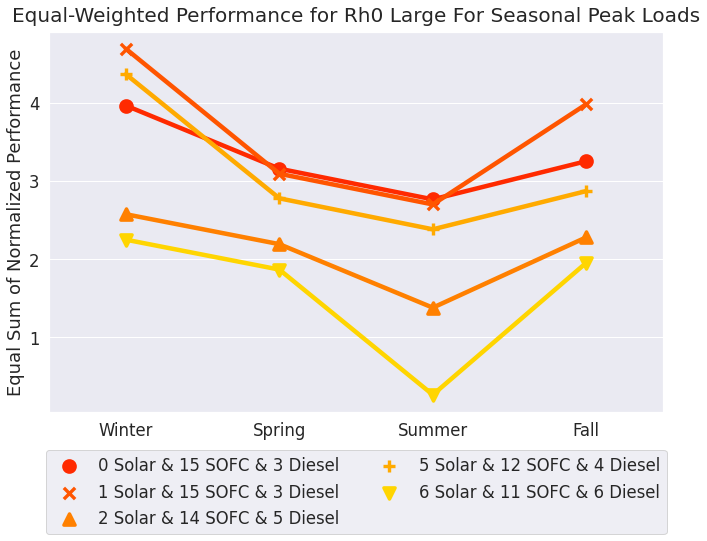

In [55]:
sb.set(font_scale=1.5)
rcParams['figure.facecolor'] = 'white'


equal_weight_obj = weight_obj("equal_weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.2,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.2,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.2,
    CRITERIA[6]:0.2
})

create_nd_seasonal_performance_line_graph(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/SeasonalPerformance"),
    length="short",
    system_type="generated",
    network="RH0_large",
    color_palette="autumn",
    no_sox_no2=True,
    save_image=False,
    weights=equal_weight_obj)

In [50]:
def compare_RHs_all_seasons(
    datafolder, plotfolder, no_sox_no2=False, font_size = 20, axis_font_size=20, marker_size=50, save_image=True, system_type="generated",
    networks=["RH0_large", "RH2_small"], nd_season="winter", duration="short", weights=None):
    
    mpl.rcParams['lines.markersize'] = str(marker_size)
    min_val = None
    max_val = None
    
    season_dfs = []

    
    nd_indices = [None, None]
    nd_cases = ["_".join([networks[0], nd_season, "max", duration]), "_".join([networks[1], nd_season, "max", duration])]
    for idx, nd_case in enumerate(nd_cases):
        nd_case_filepath = datafolder.joinpath(f"{nd_case}_nd.csv")
        nd_case_data = read_csv(nd_case_filepath, index_col=[0])
        nd_indices[idx] = nd_case_data.index

    for i in [0,1]:
        season_dfs.append([])
        for season in seasons:
            case = "_".join([networks[i], season, "max", duration])
            if season==nd_season:
                case_filepath = datafolder.joinpath(f"{case}_nd.csv")
                case_data = read_csv(case_filepath, index_col=[0])
            else:
                case_filepath = datafolder.joinpath(f"{case}_{system_type}.csv")
                case_data = read_csv(case_filepath, index_col=[0])
                case_data = case_data.loc[[ind for ind in nd_indices[i]]]
            
            if no_sox_no2:
                case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
            min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min, 0)
            max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max, 0)

            season_dfs[i].append(case_data)
        
    normalized_dfs = []
    melted_dfs = []
    for i in [0,1]:
        normalized_dfs.append([])
        melted_dfs.append([])
        for season_data in season_dfs[i]:
            normalized_season_data=(max_val-season_data)/(max_val-min_val)
            normalized_season_data.fillna(0, inplace=True)
            if no_sox_no2:
                criteria_list = CRITERIA.copy()
                del criteria_list[4]
                del criteria_list[2]
            else:
                criteria_list = CRITERIA
            normalized_season_data["weighted_score"] = sum((normalized_season_data[criterion] * (weights.get_weight(criterion) if weights is not None else 1) for criterion in criteria_list))
            normalized_season_data["Index"] = normalized_season_data.index
            normalized_season_data = normalized_season_data[['Index', 'weighted_score']]
            normalized_dfs[i].append(normalized_season_data)
        
        merge_01 = merge(normalized_dfs[i][0], normalized_dfs[i][1], on='Index', how='inner', suffixes=(f"_{seasons[0]}", f"_{seasons[1]}"))
        merge_23 = merge(normalized_dfs[i][2], normalized_dfs[i][3], on='Index', how='inner', suffixes=(f"_{seasons[2]}", f"_{seasons[3]}"))
        merge_4 = merge(merge_01, merge_23, on="Index", how="inner", suffixes=(None,None))
        if len(merge_4) == 0:
            print("No systems are evaluated across all seasons")
            continue
        # merge_4.set_index("Index", inplace=True)
        melted_dfs[i] = melt(merge_4, id_vars = ["Index"])
        # melted_df.set_index("Index", inplace=True)
    
    plt.figure(figsize=(11,7))
    mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])
    
    with plt.rc_context({'lines.linewidth': 2.5}):
        
        ax = sb.pointplot(data=melted_dfs[0], x="variable", y="value", hue="Index", errorbar=None, palette="autumn", markers=[next(mks) for i in melted_dfs[0].index.unique()])#keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_df["Index"].values))
        
        dummy1, = plt.plot([0], marker='None',
                linestyle='None', label='RH0 Non-Dominated Options')
        plot1_collections = list(ax.collections).copy()
        sb.pointplot(data=melted_dfs[1], x="variable", y="value", hue="Index", errorbar=None, palette="cool", markers=[next(mks) for i in melted_dfs[1].index.unique()])
        dummy2, = plt.plot([0], marker='None',
                linestyle='None', label='RH2 Non-Dominated Options')
        plot2_collections = [collection for collection in ax.collections if collection not in plot1_collections]
        
        
    ax.set(xlabel=None, ylabel="Weighted Sum of Normalized Performance")
    # plt.title(f"Equal-Weighted Performance for {' & '.join([case.replace('_', ' ').title() for case in networks])} {nd_season.title()} Non-Dominated Set For Seasonal Peak Loads", fontsize=20, pad=10)
    ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text().split("_")[-1].title(), 9)) for ticklabel in ax.get_xticklabels()])
    plt.legend(

        [dummy1] + plot1_collections + [dummy2] + plot2_collections,
        ["RH0 Non-Dominated Options"] + [collection.get_label() for collection in plot1_collections] + ["RH2 Non-Dominated Options"] + [collection.get_label() for collection in plot2_collections],
        loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=2)
    if save_image:
        ax.figure.savefig(plotfolder.joinpath(f"{'_'.join(networks)}_{nd_season}_comparison{('_' + weights.get_name()) if weights is not None else ''}.png"), bbox_inches = "tight")

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.4, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.8, 0.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



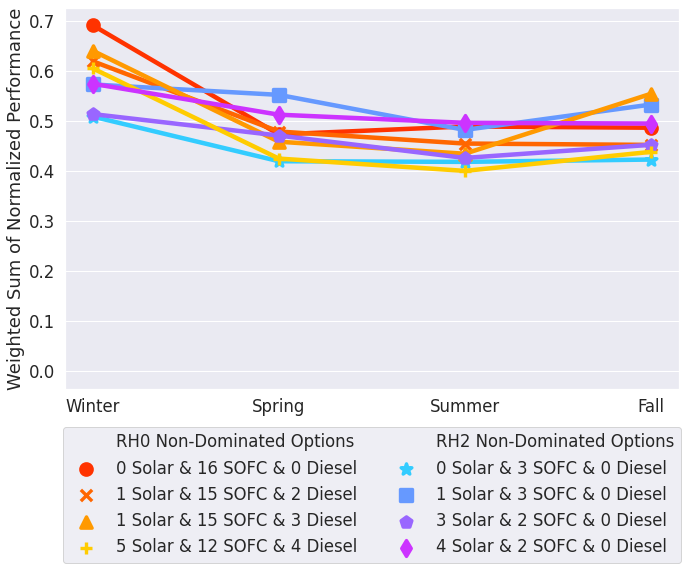

In [61]:
equal_weight_obj = weight_obj("equal_weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.2,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.2,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.2,
    CRITERIA[6]:0.2
})

climate_change_obj = weight_obj("climate_change", {
    CRITERIA[0]:0.1,
    CRITERIA[1]:0.6,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.1
})

health_obj = weight_obj("health", {
    CRITERIA[0]:0.1,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.6,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.1
})

outage_mitigation_obj = weight_obj("outage_mitigation_weighting", {
    CRITERIA[0]:0.1,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.6
})

economical_outage_mitigation_obj = weight_obj("economical_outage_mitigation_weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.5
})

dependability_obj = weight_obj("dependability_weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.4,
    CRITERIA[6]:0.2
})

compare_RHs_all_seasons(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/SeasonalPerformance"),
    no_sox_no2=True,
    font_size=20,
    axis_font_size=24,
    weights=economical_outage_mitigation_obj,
    save_image=True
    )